# **Matching Districts Based on Time-Series Trend:**

I use weekly Order/Retailer from January to March 2023 to try to match most similar districts.

In [ ]:
#@title
!pip install fastdtw

**Exploratory Time-Series Plot:**

I plot the weekly Order/Retailer time series of all the districts on the same plot

But the timeseries are not balanced for the districts...

There are many ways you are determine the similarity between two input time series. For example:


1.   Dynamic Time Warping
2.   Using log(mean) + standard deviations as a distance measure used by Deryugina et al. (2020)

I use DTW here



In [ ]:
# Freq,TS, Retention

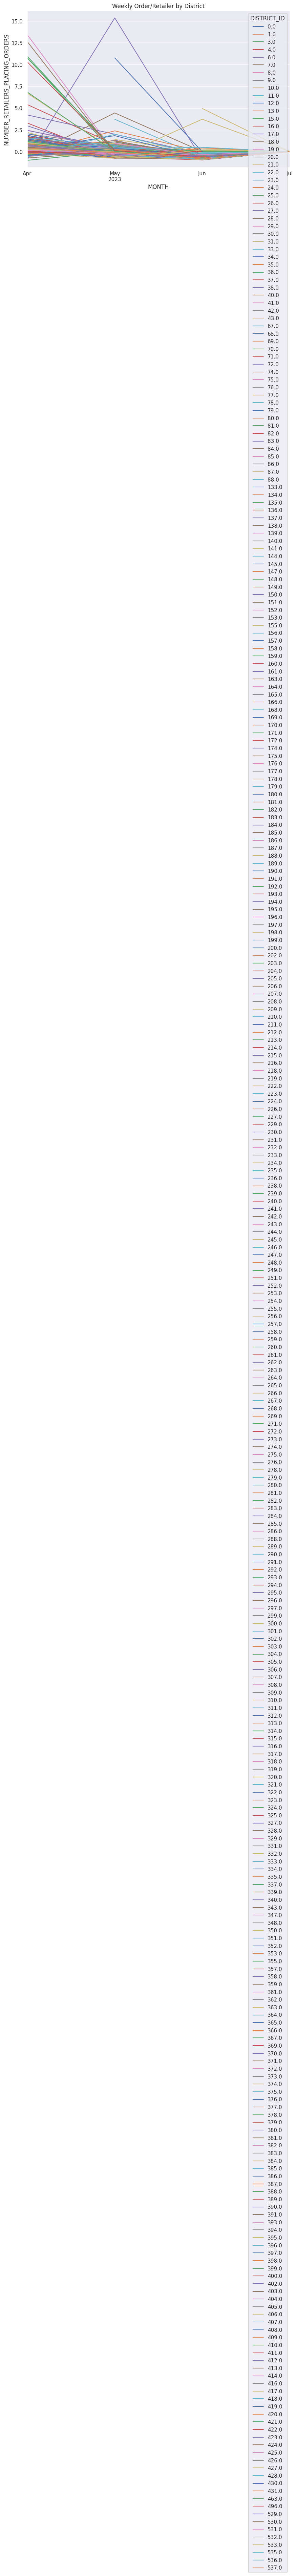

In [ ]:
import pandas as pd

# load data into a pandas DataFrame
data = pd.read_csv('/content/delivery_fees_non_sugar_and_retention.csv')
data = data.fillna(0)
# convert the "week" column to datetime format
data['MONTH'] = pd.to_datetime(data['MONTH'])
# pivot the DataFrame so that each district has its own column with WEEKly sales
pivot_data = data.pivot(index='MONTH', columns='DISTRICT_ID', values='NMV_GROWING')
# plot the time series WEEKly sales for each district
import matplotlib.pyplot as plt

pivot_data.plot(figsize=(10,6))
plt.xlabel('MONTH')
plt.ylabel('NUMBER_RETAILERS_PLACING_ORDERS')
plt.title('Weekly Order/Retailer by District')
plt.show()

# TS, Freq, NMV


In [ ]:
pivot_data1=pivot_data.fillna(0)

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np

distances = []
for i in range(len(pivot_data1.columns)):
    for j in range(i+1, len(pivot_data1.columns)):
        x = pivot_data1.iloc[:,i].values.reshape(-1, 1)
        y = pivot_data1.iloc[:,j].values.reshape(-1, 1)
        distance, path = fastdtw(x, y, dist=euclidean)
        distances.append((pivot_data1.columns[i], pivot_data1.columns[j], distance))

distances.sort(key=lambda x: x[2])
most_similar = distances[0]

df_distances = pd.DataFrame(distances, columns=['district1', 'district2', 'distance'])
# df_distances.to_csv("distances.csv")

import pandas as pd

# Convert distances list to DataFrame
dist_df = pd.DataFrame(distances, columns=['district1', 'district2', 'distance'])

# Create pivot table
pivot_table = pd.pivot_table(dist_df, index='district1', columns='district2', values='distance')

# Sort values in pivot table and get top 6 most similar districts
similar_districts = pd.DataFrame(pivot_table.apply(lambda x: x.nsmallest(4).index.tolist(), axis=1).tolist(), index=pivot_table.index, columns=['similar_district1', 'similar_district2', 'similar_district3', 'similar_district4'])


from sklearn.cluster import KMeans

# Fit KMeans clustering algorithm on the similar_districts matrix
kmeans = KMeans(n_clusters=4, random_state=0).fit(similar_districts)

# Get the labels assigned to each district by the KMeans algorithm
labels = kmeans.labels_

# Add the labels as a new column to the similar_districts DataFrame
similar_districts['cluster'] = labels


import pandas as pd

# Convert distances list to DataFrame
dist_df = pd.DataFrame(distances, columns=['district1', 'district2', 'distance'])

# Compute mean distance for each district
mean_distances = dist_df.groupby('district1')['distance'].mean().reset_index()

# Compute overall mean distance
overall_mean_distance = mean_distances['distance'].mean()

# Compute distance of each district from mean distances
mean_distances['distance_from_mean'] = abs(mean_distances['distance'] - overall_mean_distance)


#Slope calculation
def slope(x1, y1, x2, y2):
  s = (y2-y1)/(x2-x1)
  return s

slope_diff_nmv = 100
slope_diff_ts = 100
slope_diff_freq = 100

# def randomize():
while slope_diff_nmv > 0.07 or slope_diff_ts > 0.07 or slope_diff_freq > 0.07 :
  # Randomization
  mean_distances.sort_values(by='distance_from_mean',ignore_index=True,inplace=True)

  mean_distances['rand']=np.random.rand(len(mean_distances))

  mean_distances.sort_values(by='rand',ignore_index=True,inplace=True)

  #Treat and Control
  mean_distances['group']="h"
  for i in range(len(mean_distances)):
    if i <= len(mean_distances)/2:
      mean_distances['group'][i] = 'T'
    else:
      mean_distances['group'][i] = 'C'

  # Collecting Data
  df = data.merge(mean_distances,left_on='DISTRICT_ID',right_on='district1')
  df['DISTRICT_ID'] = df['DISTRICT_ID'].astype(int)

  # Seprate the Treat and Control

  treat_df = df[df['group']=='T']
  control_df = df[df['group']=='C']

    # to force a control group
#   treat_df = df[df['DISTRICT_ID'].isin([421,531,181,135,17,393,422,414,75,192,242,36,8,416,11,24,42,7,86,403,82,413,408,38,23,160,27,431,394,412])]
#   treat_copy = treat_df.copy()

#   control_df = df.drop(treat_df.index).sample(n=len(treat_df))
#   control_copy = control_df.copy()


  #Group values for the control then change to data frame
  control = control_df.groupby('MONTH').mean()

  # control.drop('level_0',axis=1, inplace=True)
  control.reset_index(inplace=True)
  control['index']=control.index


  #Group value for the treat then change to data framef
  treat = treat_df.groupby('MONTH').mean()

  # treat.drop('level_0',axis=1, inplace=True)
  treat.reset_index(inplace=True)
  treat['index']=treat.index

  slope1_nmv = np.abs(np.polyfit(control['index'], control['NMV_GROWING'], 1)[0])
  slope2_nmv = np.abs(np.polyfit(treat['index'], treat['NMV_GROWING'], 1)[0])

  slope_diff_nmv = np.abs(slope1_nmv - slope2_nmv)

  slope1_freq = np.abs(np.polyfit(control['index'], control['ORDERS_PER_RETAILER_GROWING'], 1)[0])
  slope2_freq = np.abs(np.polyfit(treat['index'], treat['ORDERS_PER_RETAILER_GROWING'], 1)[0])

  slope_diff_freq = np.abs(slope1_freq - slope2_freq)

  slope1_ts = np.abs(np.polyfit(control['index'], control['NUM_PSO_GROWING'], 1)[0])
  slope2_ts = np.abs(np.polyfit(treat['index'], treat['NUM_PSO_GROWING'], 1)[0])

  slope_diff_ts = np.abs(slope1_ts - slope2_ts)

# print(slope_diff)AVG_PSO_PRICE


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-118-e30fd5b25dfe>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_distances['group'][i] = 'T'
<ipython-input-118-e30fd5b25dfe>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_distances['group'][i] = 'C'
<ipython-input-118-e30fd5b25dfe>:109: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only 

In [ ]:
print(slope_diff_nmv)
print(slope_diff_ts)
print(slope_diff_freq)

0.038589516623419945
0.05691497743276011
0.028124218415871635


<Axes: xlabel='MONTH', ylabel='NMV_GROWING'>

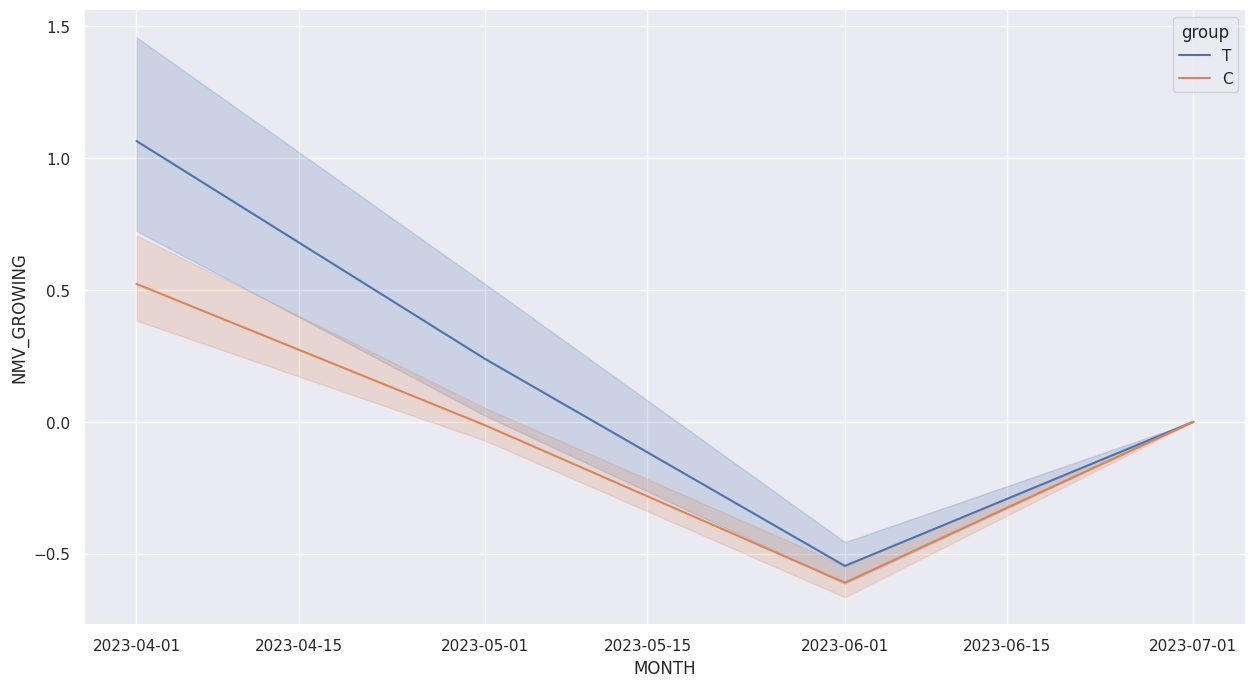

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("df")
plt.figure(figsize=(15,8))


# Plot the responses for different events and regions
sns.lineplot(x="MONTH", y="NMV_GROWING",
             hue="group",
             data=df)

<Axes: xlabel='MONTH', ylabel='ORDERS_PER_RETAILER_GROWING'>

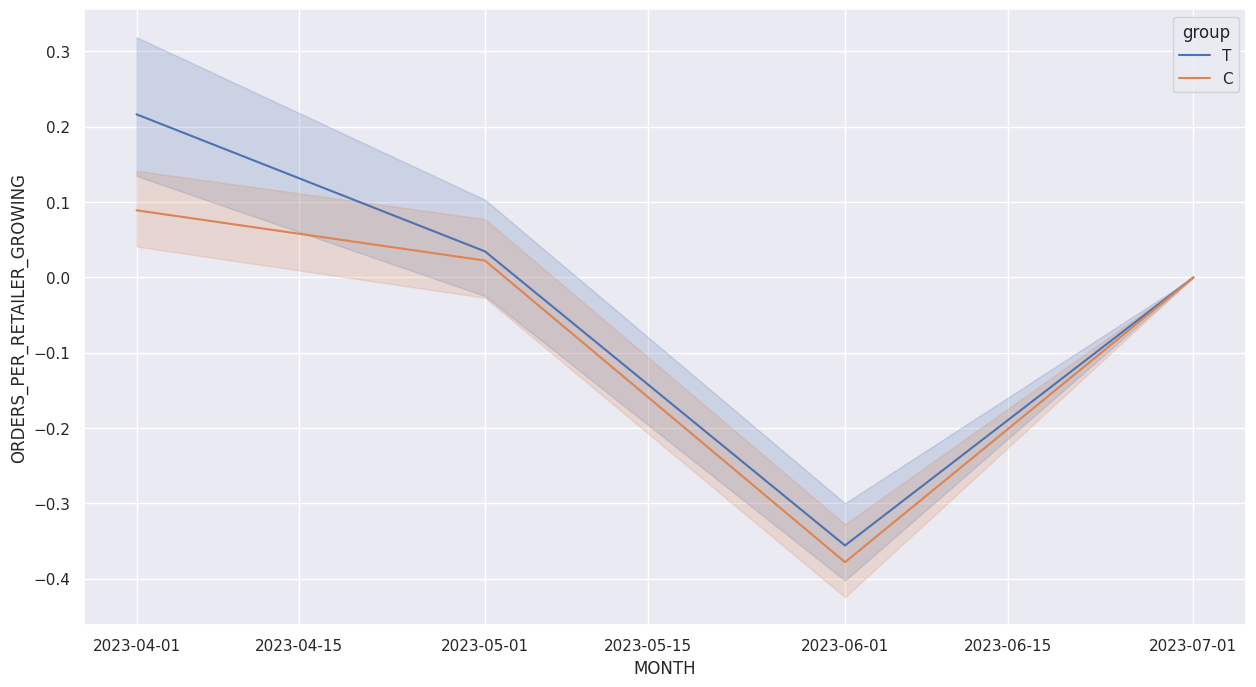

In [ ]:

sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("df")
plt.figure(figsize=(15,8))

# Plot the responses for different events and regions
sns.lineplot(x="MONTH", y="ORDERS_PER_RETAILER_GROWING",
             hue="group",
             data=df)

<Axes: xlabel='MONTH', ylabel='NUM_PSO_GROWING'>

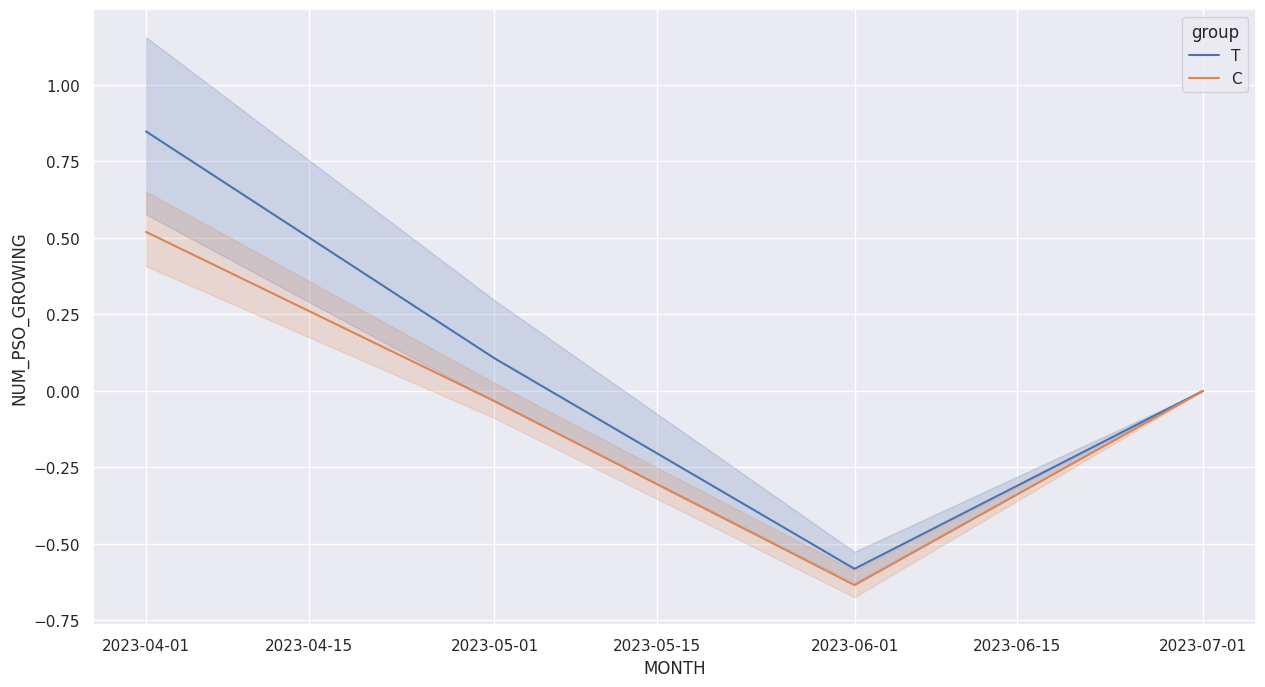

In [ ]:
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("df")
plt.figure(figsize=(15,8))

# Plot the responses for different events and regions
sns.lineplot(x="MONTH", y="NUM_PSO_GROWING",
             hue="group",
             data=df)

<Axes: xlabel='MONTH', ylabel='RETENTION_RATE'>

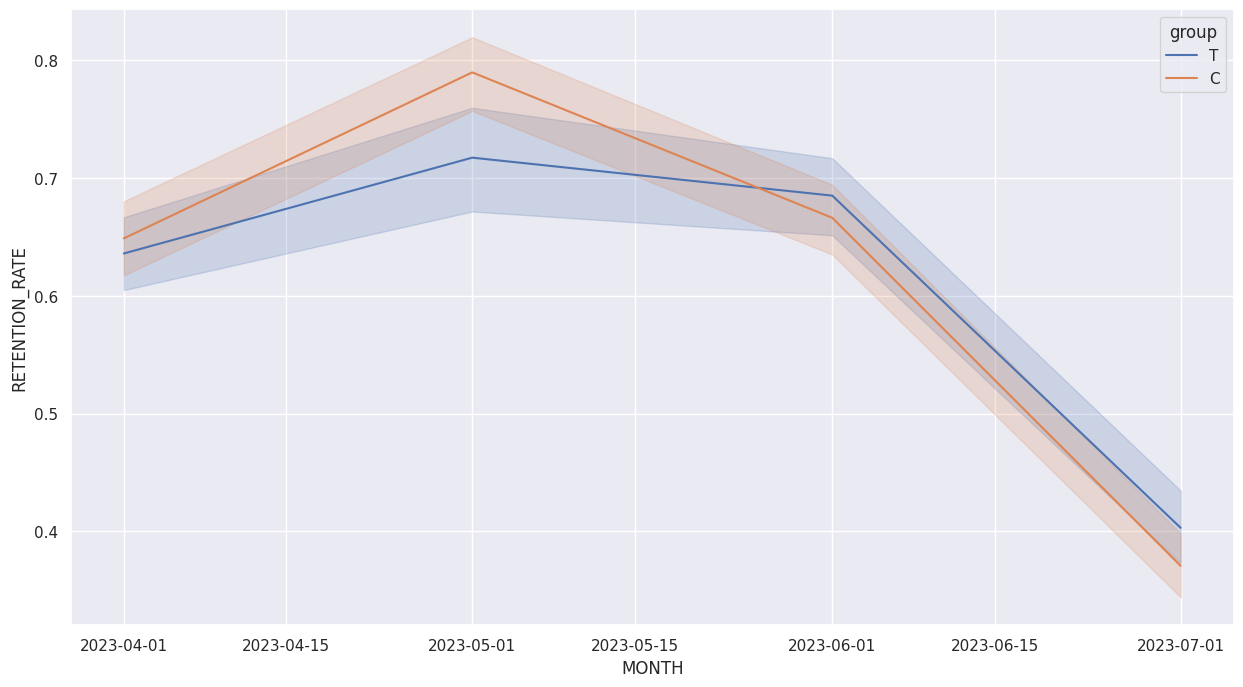

In [ ]:
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("df")
plt.figure(figsize=(15,8))

# Plot the responses for different events and regions
sns.lineplot(x="MONTH", y="RETENTION_RATE",
             hue="group",
             data=df)

In [ ]:
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("df")
plt.figure(figsize=(15,8))

# Plot the responses for different events and regions
sns.lineplot(x="MONTH", y="NUM_PSO_GROWING",
             hue="group",
             data=df)

In [ ]:
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("df")
plt.figure(figsize=(15,8))

# Plot the responses for different events and regions
sns.lineplot(x="MONTH", y="NUM_PSO_GROWING",
             hue="group",
             data=df)

In [ ]:
control.describe()

,CITY_ID,DISTRICT_ID,RETENTION_RATE,NUMBER_RETAILERS_PLACING_ORDERS_GROWING,ORDERS_PER_RETAILER_GROWING,NUM_PSO_GROWING,NUM_DELIVERED_PSO_GROWING,GMV_GROWING,NMV_GROWING,NMV_PER_RETAILER_GROWING,RETAILERS_500_GROWING,RETAILERS_700_GROWING,RETAILERS_800_GROWING,RETAILERS_800_GROWING.1,district1,distance,distance_from_mean,rand,index
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,7.537263,249.222991,0.633271,-0.036283,-0.021712,0.002820,-0.010660,0.161847,0.153404,0.125246,0.043398,-0.201291,-0.194963,-0.196325,249.222991,0.978671,0.221684,0.532903,1.500000
std,2.361630,20.167122,0.197677,0.337501,0.094044,0.389963,0.388983,0.414917,0.416578,0.102174,0.652376,0.269761,0.243826,0.236397,20.167122,0.054163,0.038595,0.032796,1.290994
min,4.066667,233.677419,0.354729,-0.517956,-0.147607,-0.540798,-0.558472,-0.348106,-0.366299,0.000000,-0.661578,-0.596945,-0.551620,-0.485922,233.677419,0.928990,0.182964,0.485066,0.000000
25%,7.243939,237.789355,0.589366,-0.129489,-0.050800,-0.135199,-0.139618,-0.087027,-0.091575,0.063626,-0.226408,-0.253101,-0.227799,-0.340989,237.789355,0.948400,0.197682,0.525054,0.750000
50%,8.361193,242.307273,0.678619,0.059274,-0.009266,0.100290,0.094599,0.224996,0.237453,0.140563,-0.040676,-0.104109,-0.114116,-0.149689,242.307273,0.965562,0.215786,0.545045,1.500000
75%,8.654516,253.740909,0.722523,0.152479,0.019823,0.238310,0.223558,0.473870,0.482431,0.202184,0.229131,-0.052299,-0.081281,-0.005025,253.740909,0.995833,0.239788,0.552894,2.250000
max,9.360000,278.600000,0.821119,0.254274,0.079291,0.351498,0.326635,0.545505,0.505007,0.219858,0.916522,0.000000,0.000000,0.000000,278.600000,1.054567,0.272198,0.556459,3.000000


In [ ]:
treat

,MONTH,CITY_ID,DISTRICT_ID,RETENTION_RATE,NUMBER_RETAILERS_PLACING_ORDERS_GROWING,ORDERS_PER_RETAILER_GROWING,NUM_PSO_GROWING,NUM_DELIVERED_PSO_GROWING,GMV_GROWING,NMV_GROWING,NMV_PER_RETAILER_GROWING,RETAILERS_500_GROWING,RETAILERS_700_GROWING,RETAILERS_800_GROWING,RETAILERS_800_GROWING.1,district1,distance,distance_from_mean,rand,index
0,2023-04-01,27.689655,203.896552,0.674395,0.244921,0.118899,0.369718,0.370319,0.461316,0.484979,0.243837,1.555200,0.247462,0.145729,0.000423,203.896552,0.923985,0.245201,0.628168,0
1,2023-05-01,27.166667,214.800000,0.723552,-0.124871,-0.032295,-0.134855,-0.163401,-0.099681,-0.114986,0.026189,-0.014182,-0.107631,-0.111686,-0.124716,214.800000,0.918137,0.246201,0.637587,1
2,2023-06-01,27.166667,214.800000,0.678511,-0.491943,-0.480955,-0.691453,-0.731753,-0.637425,-0.680816,-0.298910,-0.632408,-0.547285,-0.401630,-0.457387,214.800000,0.918137,0.246201,0.637587,2
3,2023-07-01,27.166667,214.800000,0.403051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214.800000,0.918137,0.246201,0.637587,3


In [ ]:
control_copy['tag']='control'
treat_copy['tag']='treat'

delievery = control_copy.append(treat_copy, ignore_index=True)
delievery.to_csv('timewarp.csv')

<ipython-input-125-14480a44c5ef>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  delievery = control_copy.append(treat_copy, ignore_index=True)
